# **Coupling grids with different geometries and scales: an example from fluvial geomorphology**

$by$ $Shelby$ $Ahrendt^{1},$ $Josie$ $Arcuri^{2},$ $Eric$ $Barefoot^{3},$ $Rachel$ $Bosch^{4},$ $François$ $Clapuyt^{5},$ $Hima$ $Hassenruck$ $Gudapati^{6},$ $Vinicius$ $Perin^{7},$ $Edwin$ $Saavedra$ $Cifuentes^{8},$ $and$ $Mohit$ $Tunwal^{9}$
```
1. University of Washington, 2. Indiana University, 3. Rice University, 4. University of Cincinnati, 
5. Université Catholique de Louvain, 6. University of Texas Austin, 7. North Carolina State University, 
8. Northwestern University, 9. Penn State University
```


## Conceptual model
This activity couples Five Landlab components--NetworkSedimentTransporter, ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter, SpatialPrecipitation Distribution, OverlandFlow, and SoilInfiltrationGreenAmpt--to simulate a floodplain response. Beginning with a digital elevation model (DEM) of a small watershed as a raster grid, a channel network is identified and extracted as a network grid. A rain event is then applied as a thin layer of water over the raster grid.

<img src="https://i.imgur.com/jS8EqiI.jpg" alt="conceptual framework" width="500"/>

## Learning Objectives

### *Fluvial geomorphology objectives*

*Given a structured Jupyter notebook with parameters that can vary, students will have the opportunity to explore the synergistic effects of the following geomorphic parameters*: rainfall intensity, rainfall distribution, sediment supply, and infiltration properties on overbank flow in a floodplain.

### Software engineering objectives

*Through implementing this coupled notebook, students will be able to design a jupyter notebook to practice the following skills in Python*: Introduce two model grid types (network and rectilinear); connect these two grids by layering them on top of each other; and connect two rectilinear grids by having output of one feed into the input for another.


In [1]:
# Import some basic packages
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
import shutil

## 1. Drainage network topology

### 1.1 Import topography from a raster
A raster file containing the topography of an area is loaded as a Landlab grid which will be stored as rmg. In this case, we will be dealing with a two-dimensional grid composed of the tiles that make up the raster file.

The elevation attribute read from this raster is stored as z, which is connected to the fixed name 'topographic__elevation'.

In [2]:
# Package for reading raster files
from landlab.io.esri_ascii import read_esri_ascii, write_esri_ascii

# Read raster as Landlab grid and assign info in raster as z.
PATH_TO_TOPOGRAPHY = './data/hugo_site.asc'
rmg, z = read_esri_ascii(PATH_TO_TOPOGRAPHY, name='topographic__elevation')

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# Nodes with an elevation of -9999 are considered empty => interpreted as closed boundaries in the system
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED
rmg.set_watershed_boundary_condition('topographic__elevation')

Let's check the topography of this basin. Notice that we plot the `'topographic__elevation'` of the grid `rmg`, rather than plotting the `z` variable that we stored before. However, `z` points to `'topographic__elevation'`. 

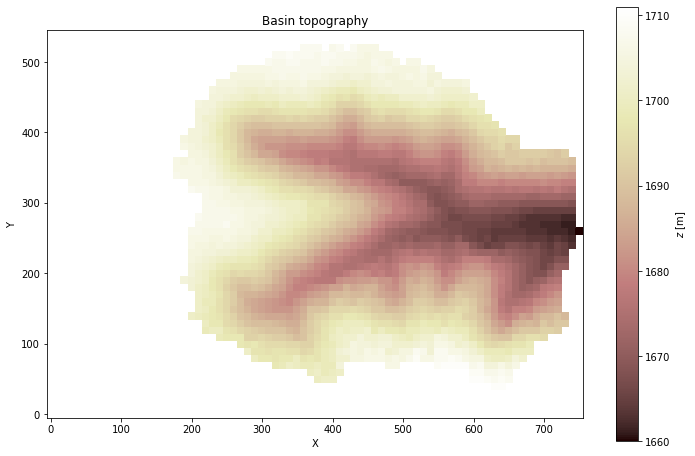

In [4]:
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

# Plot topography
plt.figure(figsize=(12,8))
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]")
plt.show()

### 1.2 Create channel network

We start by finding the drainage network and defining a minimum flow accumulation to define the channel using the FLowAccumulation and ChannelProflier packages.

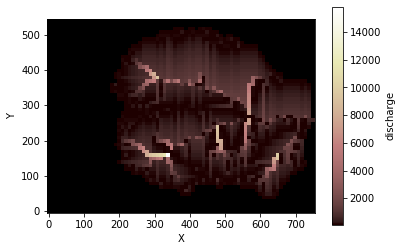

In [5]:
# Package for finding flow accumulation in each grid cell
from landlab.components import FlowAccumulator

fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

That doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

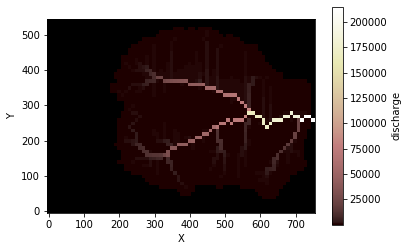

In [6]:
# Package for finding water accumulation depressions
from landlab.components import DepressionFinderAndRouter

df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

imshow_grid_at_node(rmg,
                    rmg.at_node['surface_water__discharge'],
                    colorbar_label='discharge')

Use the channel profiler to extract channels. The `'min_channel_thresh'` will define the threshold of flow accumulation required for a channel to be identified:
* note, toggle minimum channel threshhold to refine network!

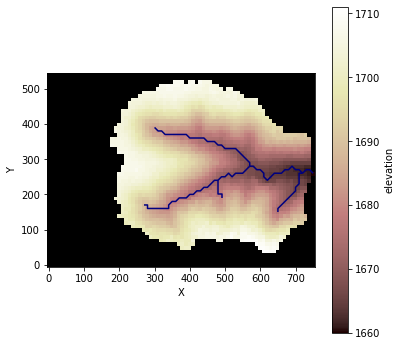

In [7]:
# Package for using water accumulation to exctract Channel profiler.
from landlab.components import ChannelProfiler
min_channel_thresh = 10000

profiler = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=min_channel_thresh,
    main_channel_only=False,
    cmap='jet',
)
profiler.run_one_step()

plt.figure(figsize = (6,6))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')

What does the elevation of the channels look like going upstream?

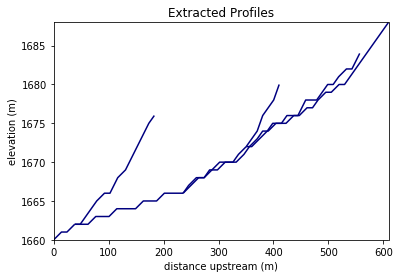

In [8]:
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)')

### 1.3 Create channel network grid
Now we create a `network_grid`. This network is composed of nodes and links, meaning it will work as a one-dimensional grid. We interate through the watershed segments of the Channel profiler to define nodes at regular intervals `'d_node_spacing'`
* Note: both of the following should be considered when setting node spacing as it is known to screw up grid connectivity
    * d_node_spacing cannot be longer than shortest link segment (should create exception for this)
    * d_node_spacing should be greater than grid resolution

In [9]:
d_node_spacing = 20 #units to space nodes, must be greater than grid resolutio

#obtain watershed key
ws_keys = [k for k in profiler.data_structure.keys()]

#sent message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('more than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

Now we loop through each watershed segment to define the links and nodes of the `network_grid`.

In [10]:
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each channel segment
nodes_per_segment = [] #empty list to store number of nodes in each channel segment

links = [] #empty list to store links of network model grid
node_xy = []#empty list to store xy locations of network model grid nodes

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    
    #access individual segment
    seg_i = profiler.data_structure[ws_keys[0]][seg_key] 
    #print(seg_i)
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    nodes_per_segment.append(n_possible_nodes)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #find links for x,y values
    n = 0
    while n < (n_possible_nodes-1):
            
            head_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n]]])
            tail_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n+1]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n+1]]])
            
            #the code below is taken from the read_shapefile landlab code
            
            # we should expect that the head node and tail node of later links will
            # already be part of the model grid. So we check, and add the nodes,
            # if they don't already exist.

            if head_node_xy not in node_xy:
                node_xy.append(head_node_xy)

            if tail_node_xy not in node_xy:
                node_xy.append(tail_node_xy)

            # get the index of the head and tail node index.
            head_node__node_id = node_xy.index(head_node_xy)
            tail_node__node_id = node_xy.index(tail_node_xy)

            # append the head and tail node ids to the link array
            links.append((head_node__node_id, tail_node__node_id))
            n+=1
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

#get unique nodes
xy_df = pd.DataFrame({'x': x_of_nodes, 'y': y_of_nodes})
uniq_x_of_nodes = xy_df.drop_duplicates()['x'].values
uniq_y_of_nodes = xy_df.drop_duplicates()['y'].values

Label the watershed segments by their id number and color nodes according to their watershed segement

Text(0.5, 1.0, 'Network Nodes colored by channel segment')

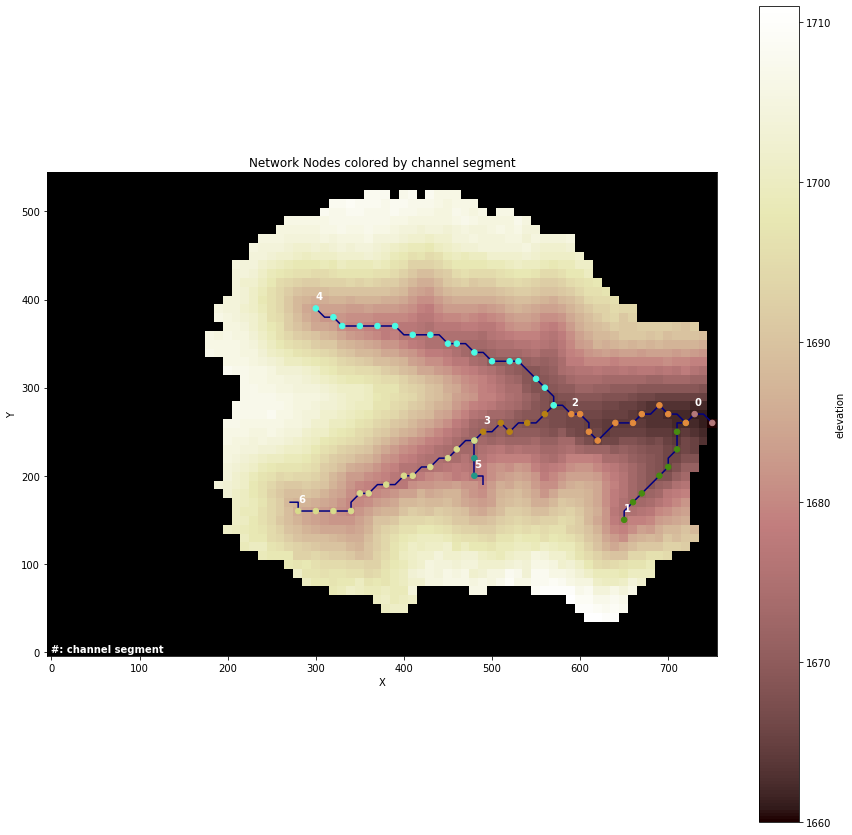

In [11]:
plt.figure(figsize = (15,15))
profiler.plot_profiles_in_map_view(colorbar_label='elevation')
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)

#hacky way to label channel segments with #s -------
node_id = 0 #dummy counter
idx_x = [] #store indexes to acces x,y location of last node on channel
#loop through channels, get node index
for node_len in nodes_per_segment:
    node_id+=node_len
    idx_x.append(node_id-1)
#plot numbers at last node for each channel seg
for i in range(n_channel_segs):
    plt.text(x_of_nodes[idx_x[i]],
             y_of_nodes[idx_x[i]]+10,
             '%d'%i,
             color='white',
             fontweight='bold')
plt.text(0,0,
         '#: channel segment',
         color='white',
         fontweight='bold')
#---------------------------------------------------
plt.title('Network Nodes colored by channel segment')

This does not include any links at triple junctions. Adding the connectivity at triple junctures:

In [12]:
#extract channel start and end nodes so we can see where there are junctures by checking for similar start and end nodes
channel_start_nodes = np.array([n1 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])
channel_end_nodes = np.array([n2 for (n1, n2) in profiler.data_structure[ws_keys[0]].keys()])

#find idx of link per segment-----------------
# Need to correct for number of links per segment 
# channel segments ending in a channel head have (n-1 links per n nodes) 
# segments which connect to the network upstream have (n links per n nodes)
links_per_segment = np.array(nodes_per_segment.copy())
for i in range(n_channel_segs):
    #if channel end nodes do not exist in starting nodes, they must be channel heads
    #channel heads will not be linked to the rest of the network so let's adjust our number of links accordingly
    if not np.any(channel_end_nodes[i] == channel_start_nodes):
        #subract a link if channel head
        links_per_segment[i] -= 1

#iterate through channel segs to add link connections at appropriate nodes
for seg in range(n_channel_segs):
    #create array that functions as cumulative index of nodes in every channel segment
    node_ids = np.cumsum(links_per_segment)
    #check if a channel segment end node exists in the start of any other node
    if channel_end_nodes[seg] in channel_start_nodes:
        #find the first place where this is equal
        first_id_equal = np.where(channel_end_nodes[seg] == channel_start_nodes)[0][0]
        #figure out how many segments ahead this is 
        #(also currently need to subtract 1 since my node_ids don't start at zero, should make this more clean, by inserting zero at beginning)
        id_up = first_id_equal - seg - 1
        #use 'id_up' to access the correct node to link the end of a triple-juncture segment to the nearest upstream node
        links.append((node_ids[seg] - 1, node_ids[seg+id_up]))

Now we are ready to create a network model grid with the list of  nodes and linkes found.

In [13]:
# Package for building a Network Model Grid
from landlab.grid.network import NetworkModelGrid
# Package for building a building a Network Graph
from landlab.graph.graph import NetworkGraph

x_of_node, y_of_node = zip(*node_xy)

# We want to ensure that we maintain sorting, so start by creating an
# unsorted network graph and sorting.
# The sorting is important to ensure that the fields are assigned to
# the correct links.
graph_net = NetworkGraph((y_of_node, x_of_node), links=links, sort=False)
#                        ^                    ^ ^          ^
#                        ^--Node Coordinates--^ ^-Links id-^

sorted_nodes, sorted_links, sorted_patches = graph_net.sort()

# use the sorting information to make a new network model grid.
network_grid = NetworkModelGrid(
    (np.asarray(y_of_node)[sorted_nodes], np.asarray(x_of_node)[sorted_nodes]),
    np.vstack((graph_net.node_at_link_head, graph_net.node_at_link_tail)).T,
)

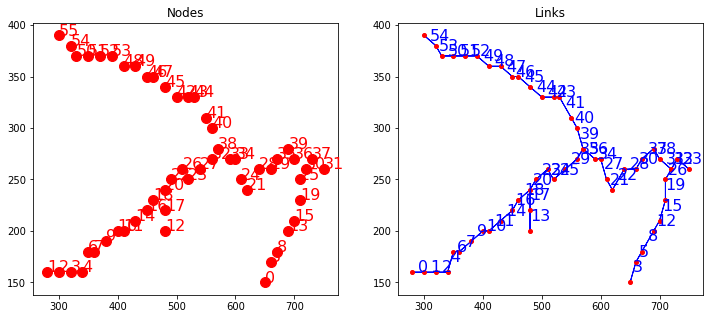

In [14]:
# Package for plotting networks
from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
graph.plot_nodes(network_grid)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(network_grid)
plt.title("Links")
plt.show()

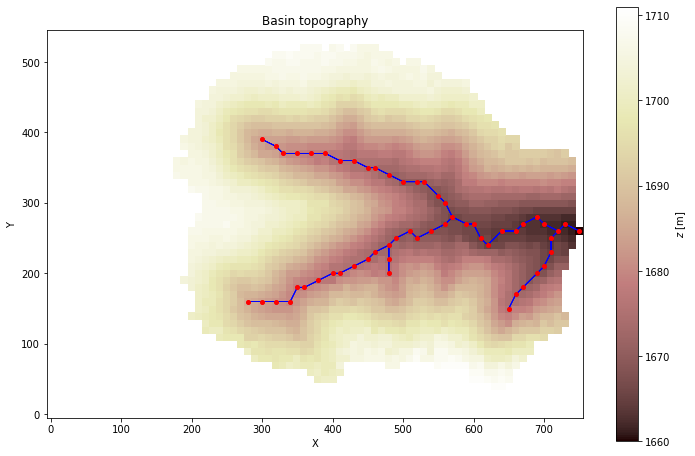

In [15]:
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

# Plot topography
plt.figure(figsize=(12,8))
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(network_grid,with_id=False)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]")
plt.show()

***
## 2. Rainfall and runoff on a topography

### 2.2 Add a storm

Rain is added as a layer of water on top of the topography imported before. For the overland flow model, this is done by adding information to the `surface_water__depth` attribute of the grid `rmg` we are working on. 

First, we can add a homogeneous rain falling over the whole domain just by populating `surface_water__depth` with a constant value `h_init`.

In [16]:
# Initial thin layer of water (m)
h_init = 0.05 

# Start with a dry terrain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)

h = rmg.at_node['surface_water__depth']  # h >> surface water depth
h += h_init                              #add a little bit of water everywhere

Similarly, a spatially variable rain pattern can be added modifying the array `h`. In this case, we add some more rain in a rectagular region. 

In [17]:
# Create a list of indexes where to add the rain
bools = (rmg.node_y > 100)*(rmg.node_y < 450)*(rmg.node_x < 400)*(rmg.node_x > 200)

# Add the rain only to the indexes defined above
h[bools] = 0.15 #initial water depth m

Let's check how this rain is distributed on the basin by plotting `h` with the `imshow_grid` function. 

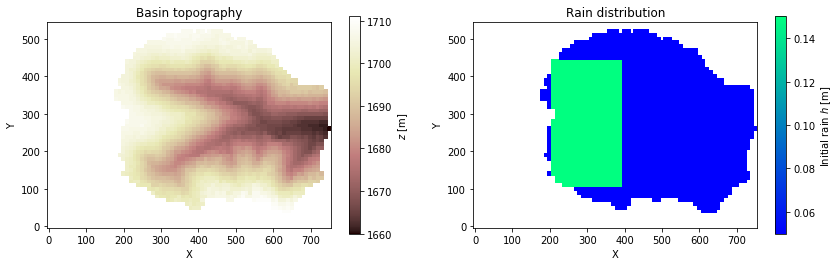

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]",\
            output=None,shrink=0.5)
plt.subplot(1,2,2)
imshow_grid(rmg, h,\
            plot_name="Rain distribution",\
            color_for_closed=None,\
            colorbar_label="Initial rain $h$ [m]",\
            cmap="winter",output=None,shrink=0.5)
plt.show()

### 2.3 Calculate the discharge

The rain field will act as the initial condition for the Overland Flow model to calculate the discharge in the basin. We start by initializing the `surface_water__discharge` attribute in `rmg`.

In [19]:
## Set inital discharge to zero
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

***
## 3. Sediment transport

****************************
I'm here :B

In [20]:
# Initial conditions
run_time =50000# 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [21]:
nmg_node_topo = np.zeros(network_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(network_grid.number_of_nodes)

for i in range(network_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([network_grid.x_of_node[i], network_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

nmg_link_length = np.zeros(network_grid.number_of_links)
nmg_link_h = np.zeros(network_grid.number_of_links)

In [22]:
for i in range(network_grid.number_of_links):
    idx_node_1_link = network_grid.nodes_at_link[i][0]
    idx_node_2_link = network_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((network_grid.x_of_node[idx_node_2_link] - network_grid.x_of_node[idx_node_1_link])**2 
                         + (network_grid.y_of_node[idx_node_2_link] - network_grid.y_of_node[idx_node_1_link])**2)
    square_idx = rmg.find_nearest_node([network_grid.x_of_node[idx_node_1_link], network_grid.y_of_node[idx_node_1_link]]) #get raster grid idx closest to link tail
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][square_idx] #assign surface at square_idx to network grid

network_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

network_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

network_grid.at_link["channel_width"] = 10 * np.ones(network_grid.number_of_links)

network_grid.at_link["flow_depth"] = nmg_link_h.copy()

network_grid.at_link["reach_length"] = nmg_link_length

In [23]:
from landlab.components import SpatialPrecipitationDistribution

# Folder for rainfall data
dir_rainfall = r'./rainfall_series'
# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 100
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 10.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms_steps = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms_steps.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1

#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii(dir_rainfall + '/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)



In [24]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(network_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.002 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [25]:
from landlab.data_record import DataRecord
from landlab.components import NetworkSedimentTransporter

lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}


items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    network_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

dt_sed = 100 # 60 * 60 * 24 *1# length of timestep (seconds) 

ImportError: cannot import name 'NetworkSedimentTransporter' from 'landlab.components' (C:\ProgramData\Anaconda3\lib\site-packages\landlab\components\__init__.py)

In [28]:
# set up overland flow grid for small-scale floodplain

Channel_Width = 8.
Channel_Depth = 2.

nX = 200
nY = 100
spacing = 1.0
Datum = 1665.0 + Channel_Depth
h_initFP = 0.1


def makeFP(Channel_Depth, Channel_Width = 8):
    
    #Define grid
    nX = 200
    nY = 100
    spacing = 1.0
    Datum = 1665.0 + Channel_Depth
    h_initFP = 0.1

    _grd = RasterModelGrid((nX, nY), xy_spacing=1.)

    # Pointer to topographic elevation > z
    _z = np.ones(nX*nY) * Datum
    _z = _grd.add_field('topographic__elevation', _z, at='node')

    # Add a longitudinal slope 
    ## (makes thing flow north to south)
    Long_Slope = 1./1000
    _z += _grd.node_y*Long_Slope

    # Add the channel indentation 
    ## (it's just a straigth strip)
    
    isChannel = (_grd.node_x > (nY/2 - Channel_Width/2)) * (_grd.node_x < (nY/2 + Channel_Width/2))
    _z[isChannel] -= Channel_Depth

    # Add a slope to the banks
    ## (so water flows always towards the main channel)
    Transversal_Slope = 1./100
    _z += np.abs(_grd.node_x-(nY/2))*Transversal_Slope

    # Add some random noise to the floodplains
    ## (makes the hillshading look prettier)
    _z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 
    
    return _grd, _z, isChannel


In [29]:
from landlab import RasterModelGrid
gridFP, zFP, isChannel = makeFP(Channel_Depth = 2)

In [30]:
# Pointer to surface water depth in the 2D floodplain
hFP = np.zeros(nX*nY)
bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)
hFP[bools] = Channel_Depth*0.5
hFP += h_initFP
hFP = gridFP.add_field('surface_water__depth', hFP, at='node')

#####################################
# Spatially variable hydraulic cond. 
#####################################

dFP = gridFP.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
dFP *= 0.2

hcFP = gridFP.add_ones('hydraulic_conductivity', at='node')
hcFP *= 1.0E-5

infBandWidthNorm = 0.3
infBandWidth = nY/2 * infBandWidthNorm

channel_left = (nY + Channel_Width) / 2
channel_right = (nY - Channel_Width) / 2

#Define high infiltration bands at the banks

highInfBand = np.logical_and(gridFP.x_of_node < channel_left + infBandWidth, 
                             gridFP.x_of_node > channel_right - infBandWidth)
inf_maskFP = np.logical_xor(highInfBand, isChannel)

hcFP[inf_maskFP] *= 10

In [27]:
from landlab.components import OverlandFlow, FlowDirectorSteepest
from landlab.components import SoilInfiltrationGreenAmpt
# Initialize model components

# overland flow in the floodplain
floodplainOF = OverlandFlow(gridFP, steep_slopes=True)

# soil infiltration in the floodplain
SI = SoilInfiltrationGreenAmpt(gridFP, hydraulic_conductivity=hcFP)

# Flow direction in channel network
fd = FlowDirectorSteepest(network_grid, "topographic__elevation")
fd.run_one_step()

#network sed transporter 
nst = NetworkSedimentTransporter(    
    network_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

# overland flow in the channel network
networkOF = OverlandFlow(rmg, steep_slopes=True)
networkOF.run_one_step()

NameError: name 'gridFP' is not defined

In [ ]:
# look at hydrograph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([network_grid.x_of_node[14], network_grid.y_of_node[14]]) 
# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

In [ ]:
# Plot 2D domain topography
#Hillshading
from matplotlib.colors import LightSource
fig = plt.figure(figsize=(10,8))
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(np.reshape(zFP,[nX,nY]), vert_exag=10), cmap='gray')
plt.show()

# # Plot 2D domain hydraulic cond.
# fig = plt.figure(figsize=(10,8))
# # plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
# imshow_grid(grid,'hydraulic_conductivity')
# plt.title("Hydraulic Conductivity")
# fig.show()

# print(network_grid.at_node['topographic__elevation'][14])
# print(zFP)
# print(rmg.at_node.keys())

# cll = rmg.find_nearest_node([network_grid.x_of_node[14], network_grid.y_of_node[14]]) 

# print(cll)
# rmg.at_node['surface_water__discharge'][cll]

In [ ]:
import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

# driving the model forward in a loop
elapsed_time = 1.
run_time = 5000
iters = 0

old_channel_depth = Channel_Depth

bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)

# #Figure outputs
# mydpi = 96
# sizeFigure = 400
# system("rm -r ResultImages/*.png")

rainfall_id = 0

dt_sed = 100

run_time_slices = np.arange(500,run_time+1,dt_sed)

for t in run_time_slices:
    
    elapsed_time_FP = float(elapsed_time)
    
    while elapsed_time < t:
    
        # make rain

        if int(elapsed_time) in scaled_days_storms:
            # print("STORMMMM")
            # Update rainfall dataset id
            rainfall_id += 1
            rainfall_name = 'rainfall__flux_' + str(rainfall_id)
            #print(rainfall_id)
            #print(rainfall_name)
            #print(dir_rainfall + '/rainfall_' + str(rainfall_id) + '.asc')
            # Avoid last time step
            if rainfall_id <= len(scaled_days_storms):
                # Read rainfall data
                # rmg.at_node.pop('rainfall__flux')
                read_esri_ascii(dir_rainfall + '/rainfall_' + str(rainfall_id) + '.asc', grid=rmg, name=rainfall_name)
                # Add rainfall event to water depth
                rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]
                print(np.sum(rmg.at_node[rainfall_name]))
    
        # route overland flow

        # First, we calculate our time step.
        dt_overland = 1 #networkOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        networkOF.overland_flow()
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q_output = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q_output[outlet_link_to_sample]) * rmg.dx)
        h_output = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(h_output[outlet_nearest_raster_cell]))
#         print(elapsed_time)

    # route sediment

    # updated the water depth in network graph
    for i in range(network_grid.number_of_links):
        idx_node_1_link = network_grid.nodes_at_link[i][0]
        idx_nearest_raster_cell = rmg.find_nearest_node([
            network_grid.x_of_node[idx_node_1_link], 
            network_grid.y_of_node[idx_node_1_link]])
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_nearest_raster_cell ] 
    network_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
#     print(network_grid.at_link["flow_depth"])
    
    nst.run_one_step(dt_sed)
    
  #Plot overland flow 
    fig=plt.figure(1)
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    
    # change the floodplain
    
    new_channel_depth = Datum - network_grid.at_node['topographic__elevation'][14]
    
    zFP[isChannel] += new_channel_depth - old_channel_depth
    
    old_channel_depth = new_channel_depth
    
#     set the boundary condition at the upstream end to be 

    network_grid.at_node['topographic__elevation'][14]
    
    j = 0
    
    while elapsed_time_FP < t:
        hFP[bools] = height_at_outlet[j]
        # First, we calculate our time step.
        dt_overland = 1 # floodplainOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        floodplainOF.overland_flow()
        # now, allow water to infiltrate
        SI.run_one_step(dt_overland)
        # Increased elapsed time
        elapsed_time_FP += dt_overland
        j += 1
#         print(elapsed_time_FP)
  
    #Plot overland flow 
    fig=plt.figure(2)
    imshow_grid(gridFP,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(gridFP,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
#     plt.plot(gridFP.node_x[outlet_nearest_raster_cell], gridFP.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    

In [ ]:
# Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")
plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"runoff_discharge.jpeg")
fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("runoff_waterdepth.jpeg")
## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0
sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)
fig=plt.figure(4)
plt.plot(np.asarray(parcels.time_coordinates), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,'b-',label="outlet"
        )
plt.ylim(4, 500)
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 
  

In [ ]:
    #Plot overland flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()

    #grain size
    parcel_D = parcels.dataset.D.values.copy()
    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

    # the histogram of the data
    plt.hist(parcel_D_off_grid*1000, histtype='bar')
    plt.xlabel('grain size (mm)')
    plt.ylabel('Count')
    plt.title('Histogram of grain sizes that left grid')
    plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
    plt.xlim(0, 20)
    plt.ylim(0, 4000)
    plt.grid(True)
    plt.show()
    
    print(np.abs(h[outlet_nearest_raster_cell]))
    print(network_grid.at_node['bedrock__elevation'][14] )
    print(network_grid.at_node['topographic__elevation'][14] )
    # change floodplain
    
    #Plot sediment parcels locations
 #   fig = plot_network_and_parcels(
 #           network_grid, parcels, 
 #           parcel_time_index=len(parcels.time_coordinates)-1)
#    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
#    plt.title(f'Time = {round(elapsed_time,1)} s')
#    plt.show()
    
#     # route floodwater on floodplain
    
#     # First, we calculate our time step.
#     dt = of.calc_time_step()
#     # Now, we can generate overland flow.
#     of.overland_flow()
#     SI.run_one_step(dt)
    
#     if iters %50==0:
#         print('Elapsed time: ', elapsed_time)
#         fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
#         plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
#         imshow_grid(grid,'surface_water__depth',
#         limits=(0,1),cmap=WaterMap,                    
#         colorbar_label="Water depth (m)",                    
#         plot_name="Time = %i" %elapsed_time)
#         fig.savefig("ResultImages/" + str(iters).zfill(5) + ".png")
    
#     elapsed_time += dt
#     iters += 1

In [ ]:
print(network_grid.at_node.keys())
print(network_grid.at_node['topographic__elevation'])

In [ ]:

# Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(f"runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig("runoff_waterdepth.jpeg")


## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)

plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,
         '-',
         linewidth=3, 
        )
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 


In [ ]:
# land flow 
fig=plt.figure()
imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
imshow_grid(rmg,'surface_water__depth',limits=(0,2),cmap=cmap,colorbar_label='Water depth (m)')
plt.title(f'Time = {round(elapsed_time,1)} s')
plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
plt.show()
#     fig.savefig(

In [ ]:
network_grid

In [ ]:
parcels.time_coordinates

In [ ]:
fig = plot_network_and_parcels(
    network_grid, parcels, 
    parcel_time_index=0)
plt.title(f'Time = {round(elapsed_time,1)} s')
plt.show()
    

In [ ]:
# # plotting model results

# images=[]
# original_files=list(glob("./ResultImages/*.png"))
# original_files.sort(reverse=False)
# for file_ in original_files:
#     images.append(imageio.imread(file_))
# imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)



In [ ]:

# # Check the 2D domain topography
# fig = plt.figure(figsize=(10,8))

# ## Cross Section
# ax1 = plt.subplot(2,1,1)
# ax1.plot(grid.node_x[grid.node_y==nX/2],z[grid.node_y==nX/2],label="Cross Section")
# ax1.set_ylabel("Elevation (??)")
# ax1.set_xlabel("Distance X (??)")
# ax1.legend()

# ## Long Section
# ax2 = plt.subplot(2,1,2)
# ax2.plot(grid.node_y[grid.node_x==nY/2],z[grid.node_x==nY/2],label="Longitudinal Section")
# ax2.set_ylabel("Elevation (??)")
# ax2.set_xlabel("Distance Y (??)")
# ax2.legend()

# fig.show()

## Exercise 1. Run this simulation using a different topography.

#### Q1a: Did you choose a real DEM or a synthetic topography? How do you think that choice may have affected the behavior of the model?

*A1a*:

#### Q1b: Did you encounter any difficulties in changing the topography? Please describe them here.

*A1b*:

#### Q1c: Use the channel threshold slider to change the drainage density of the network grid. How does this change the predicted _______?

*A1c*:

## Exercise 2. Explore different rain event magnitudes and distributions.

## Exercise 3. Play with the sediment supply.

## Exercise 4. Change the infiltration properties.